# Neutron Transport and Scattering Through a Shielding Layer
*Lili Kovacs<br>
University of Manchester  
May 2023*

The Monte Carlo method is a statistical technique, relying on random sampling which can be used to predict the outcome of an event. It is especially useful in scenarios when other types of solutions are tedious, ineffective or impossible.

This project uses the Monte Carlo method to simulate a beam of thermalised neutrons striking a shield of different materials: water, lead and graphite. The beam consists of a large number of neutrons, each of them behaving randomly. We consider absorption and scattering, backscattering and transmission processes within the shield and predict what each neutron will do next after it takes a small, random step. The simulation ends, when all neutrons have been absorbed, reflected or transmitted though the shield.

# Initialisation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Concepts

This first section introduces ideas that are necessary for the simulation. We confirm the uniformity of Python's random number generator, numpy.random.uniform(), and use it along with a linear congruential generator (LCG) to generate randomly distributed coornidates in 3 dimensions and compare the results. We then use Python's random number generator to create a function that generates exponentially distributed values, and average over a set of these to confirm. These functions are then used to create isotropically distributed unit vectors and isotropic vectors with their lengths distributed according to the exponential function.

## Uniformity

We generate an array of numbers using Python's in-build random number generator, numpy.random.uniform() and then plot them on a histogram. The two dotted lines on the plots border the range of acceptable values for bin freqencies, and the dashed line shows the mean. For a uniform distribution, the acceptable deviation from the mean, $\sigma$ is just the square root of the mean. We expect about 68% of the bins to be within $1\sigma$ and over 95% to be within $2\sigma$ for a uniform distribution.

In [2]:
def uniformity_test(N, nbins, minimum, maximum):
    """
    This function generates an array of N random numbers between 'minimum' and 'maximum' and plots a histogram for them
    with 'nbins' number of bins. It plots two dotted lines to show the accepted range of frequencies for a uniform distribution
    and a dashed line for the mean of the distribution.
    """
    numbers = np.random.uniform(minimum, maximum, N)
    
    mean = N/nbins
    acceptable_variation = np.sqrt(mean)
    lower_limit = mean - acceptable_variation
    higher_limit = mean + acceptable_variation
    
    plt.hist(numbers, bins = nbins, color = 'b', alpha = 0.6)
    plt.hlines(y = mean, xmin = minimum, xmax = maximum, color = 'black', linestyles = 'dashed')
    plt.hlines(y = lower_limit, xmin = minimum, xmax = maximum, color = 'black', linestyles = 'dotted')
    plt.hlines(y = higher_limit, xmin = minimum, xmax = maximum, color = 'black', linestyles = 'dotted')
    plt.title('Uniformly distributed numbers')
    plt.xlabel('x')
    plt.ylabel('bin height')
    plt.show()

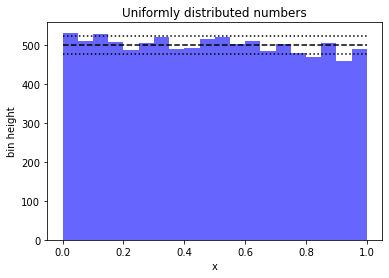

In [3]:
uniformity_test(10000, 20, 0, 1)

For 10000 entries and 20 bins, the mean (expected number of entries per bin) is 10000/20=500 and the acceptable variation is about $\pm$ 22.4. All frequencies are within or very nearly within the $1\sigma$ interval.

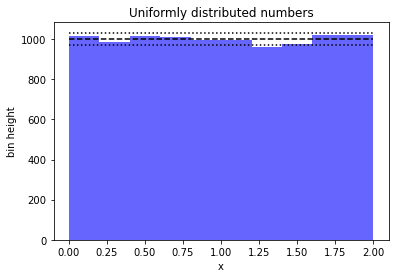

In [4]:
uniformity_test(10000, 10, 0, 2)

For 10000 entries but 10 bins, the mean is 10000/10 = 1000 and the acceptable variation is $\pm$ 31.6. We can see that the frequencies are again mostly within the accepted intervals and so we can confirm that the numbers produced by the numpy.random.uniform() function are uniform in the used range.

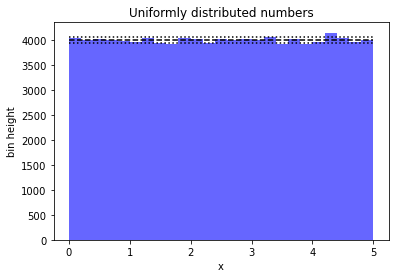

In [5]:
uniformity_test(100000, 25, 0, 5)

We can see, that if more values are generated, the function becomes "more reliable" in generating random numbers: the deviations from the accepted interval seem less frequent and relatively smaller than before.

## Two methods for randomly distributed points in 3D

We can use numpy.random.uniform() again to generate a set of random $(x, y, z)$ coordinates. These are then displayed on an interactive plot.

In [6]:
%matplotlib notebook

n = 1000 # number of points to be generated

# generate n number of x, y and z coordinates
x = np.random.uniform(0, 1, n)
y = np.random.uniform(0, 1, n)
z = np.random.uniform(0, 1, n)

fig = plt.figure()
ax = Axes3D(fig)
ax.set_box_aspect(aspect=(1,1,1))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.scatter(x, y, z, color='indianred')

<IPython.core.display.Javascript object>

Rotating the interactive scatter plot around, we don't find order of any kind from any angle.

Then a LCG is used to generate so-called pseudo-random numbers which are plotted as another set of coordinates. LCGs take a starting value ("seed") and generate a sequence of numbers using a recurrence relation.

In [7]:
def randssp(p,q):
    """
    This function is a LCG which returns an array of pseudo-random numbers.
    """
    try: b
    except NameError:
        m = pow(2, 31)
        a = pow(2, 16) + 3
        c = 0
        b = 123456789
    try: p
    except NameError:
        p = 1
    try: q
    except NameError:
        q = p
    r = np.zeros([p,q])
    for l in range (0, q):
        for k in range (0, p):
            b = np.mod(a*b + c, m)
            r[k, l] = b/m
    return r

k = randssp(3, n) # an array with 3 "dimensions" will be assigned to k, with n entries in each

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(k[0, :], k[1, :], k[2, :], color='purple')
ax.set_box_aspect(aspect=(1,1,1))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(azim=-126, elev=23)
plt.show()

<IPython.core.display.Javascript object>

In reality, LCGs produce points that lie on hyperplanes, so they are not entirely random - there are correlations between the points. This is called the spectral problem. Looking at the interactive plot we can see that the scattered points lie on equally spaced layers (which can be seen from various different angles) - the generator we used to create these points causes spectral issues, unlike numpy.random.uniform() for which the spectral problem does not happen.

## Exponentially distributed random numbers

We can use numpy.random.uniform() to create a set of numbers distributed according to the exponential function, characterinsed by $\lambda$.

To do this, we use the inverse cumulative distribution function (CDF) of the probability density function (PDF) and multiply a set of randomly distributed numbers by it. This will result in values distributed according to the original PDF, $P(x) = e^{-x/\lambda}$.

In [8]:
def exponential_generator(N, mfp):
    """
    This function produces a sample of N values distributed randomly according to an exponential function 𝑒𝑥𝑝(−𝑥/𝜆),
    where 𝜆 is the mean free path (mfp).
    """
    x = np.random.uniform(size = N)
    X = -mfp*np.log(x) # the inverse CDF of 𝑒𝑥𝑝(−𝑥/𝜆) is -𝜆*ln(𝑥)
    return X

In [9]:
def exponential_histogram_data(samples, N, bin_n, ran, lamb):
    """ 
    This function generates 'samples' exponential distributions (with a mean free path of 'lamb') of N points.
    It then bins the points, calculates the average bin height over the samples and their standard deviation.
    ('ran' is used as the range parameter for np.histogram())
    """
    
    h_arr = np.zeros((samples, bin_n)) # empty array for bin frequencies for each sample
    R_arr = np.zeros((samples, bin_n+1)) # empty array for bin borders for each sample (these are identical for each)
    
    for i in range(samples):
        X = exponential_generator(N, lamb)
        h_arr[i,:], R_arr[i,:] = np.histogram(X, bins = bin_n, range = ran)
    
    R = R_arr[0][:-1] # bins
    h = np.mean(h_arr, axis = 0)
    std = np.std(h_arr, axis = 0)
    
    return h, R, std

exponential_generator() produces a sample of N numbers distributed accoring to 𝑒𝑥𝑝(−𝑥/𝜆), where 𝜆 is the mean free path. exponential_histogram() then uses it to generate several of these distributions. It bins the generated numbers for each distribution and averages the bin heights and calculates their standard deviation. Finally, it returns the locations of the bins, their heights and the standard deviation on them. 

In the absence of scattering (so only absorption considered), the characteristic attenuation length (or mean free path) for water is about $45 cm$. Using this as the mean free path for an exponential distribution, we can confirm this.

We first average over the histograms for several samples (10 in this case, each with 10000 values) using the functions introduced above and obtain mean bin heights with standard deviations on them.  We then remove the values corresponding to empty bins from the arrays for bin heights, standard deviations and bin borders. (This prevents NaN errors when performing a linear fit later.)

We can plot the mean bin heights to visually confirm that our data is in fact exponentially distributed.

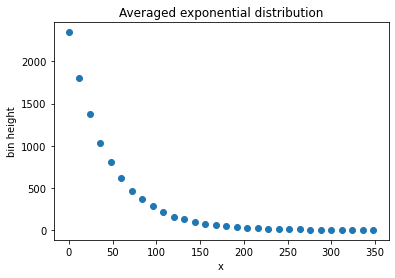

In [10]:
%matplotlib inline

water_absorption_mfp = 45 # absorption only characteristic attenuation length for water
h, R, std = exponential_histogram_data(10, 10000, 30, (0,360), water_absorption_mfp)

# remove bin data for empty bins
R=np.delete(R,np.argwhere(h==0))
std=np.delete(std,np.argwhere(h==0))
h=np.delete(h,np.argwhere(h==0))

plt.scatter(R, h)
plt.xlabel('x')
plt.ylabel('bin height')
plt.title('Averaged exponential distribution')
plt.show()

Taking the logarithm of the bin heights, we can turn the decaying exponential into a linear function.  We plot these points with their corresponding error bars ($\frac{std}{mean}$ for each bin) and perform a linear fit with np.polyfit(), using the reciprocals of the errors to weigh each point.

The characteristic attenuation length, 𝜆  and the uncertainty on it can be calculated from the fit parameters and the covariance matrix returned by np.polyfit() function.

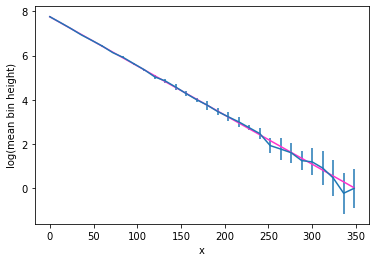

𝜆 = 44.9954 ± 0.0030 cm


In [11]:
# linear fit to logarithm of bin heights
plt.errorbar(R, np.log(h), yerr=std/h)
fit_params, fit_err = np.polyfit(R, np.log(h), 1, cov=True, w = h/std)
plt.plot(R, fit_params[0]*R+fit_params[1], color = '#ff33cc')
plt.xlabel('x')
plt.ylabel('log(mean bin height)')
plt.show()

# calculate attenuation length
lamb = -1/fit_params[0]
lamb_err = np.abs(np.sqrt(fit_err[0][0])/fit_params[0])
print('𝜆 = {:04.4f} \u00B1 {:04.4f} cm'.format(lamb, lamb_err))

## Isotropic unit vectors

The easiest way to generate random isotropic unit vectors ($|\vec{r}| = 1$ with $\vec{r} = x\vec{i} + y\vec{j} + z\vec{k}$) is to use spherical polar coordinates, generate angles θ and Φ between 0 and π or 2π and then convert them to Cartesian coordinates. However, if the θ values are generated uniformly between 0 and π, the unit vectors created will be more concentrated around the poles of a circle with a unit radius (since the rate of change of the trigonometric functions applied is not uniform.

To show this, we can create a set of evenly distributed numbers between 0 and 2π (so over one period of either of our trifonometric functions used) and take the absolute values their cosines. We can check how many of these are closer to 1 (larger than 0.5) and how many are closer to 0.

In [12]:
abs_cosines = np.abs(np.cos(np.linspace(0, 2*np.pi, 200)))
ones = np.count_nonzero(abs_cosines>0.5)
zeros = np.count_nonzero(abs_cosines<0.5)
print('values closer to 1: ', ones)
print('values closer to 0: ', zeros)

values closer to 1:  134
values closer to 0:  66


When we take a look at these, we can see that there are at least twice as many values closer to one (depending on the total number of points used). The isotropic unit vectors generated this way will therefore be more concentrated around the poles. (While the chosen boundary chosen isn't necessarily relevant to polar coordinates, it demonstrates our point of unevenly distributed trigonometric function values.)

To overcome this problem, we use a random number generated between 0 and 1 and then the arccos function to generate θ from it. The code below contains both the correct and incorrect method to create isotropic unit vectors and both sets of coordinates are plotted to show that there is a visible difference.

In [13]:
def unit_vector_wrong(N):
    """
    This function generates N random θs (between 0 and π) and Φs (between 0 and 2π) and returns
    the corresponding unit vectors r(x,y,z).
    """
    r_arr = np.zeros((N, 3))
    phi = np.random.uniform(0, 2*np.pi, N)
    theta = np.random.uniform(0, np.pi, N)
    
    r_arr[:, 0] = np.sin(theta)*np.cos(phi)
    r_arr[:, 1] = np.sin(theta)*np.sin(phi)
    r_arr[:, 2] = np.cos(theta)
    
    return r_arr

def unit_vector(N):
    """
    This function generates N random θs (by generating a random number between 0 and 1 and converting it to θs though the
    arccos function) and Φs (between 0 and 2π) and returns the corresponding unit vectors r(x,y,z).
    """
    r_arr = np.zeros((N, 3))
    phi = np.random.uniform(0, 2*np.pi, N)
    u = np.random.uniform(0, 1, N)
    theta = np.arccos(1-2*u)
    
    r_arr[:, 0] = np.sin(theta)*np.cos(phi)
    r_arr[:, 1] = np.sin(theta)*np.sin(phi)
    r_arr[:, 2] = np.cos(theta)
    
    return r_arr

def plot(N, vector_generator, mfp, colour):
    """
    This function generates a set of N vectors based on the vector_generator function passed to it and plots them on
    a scatter plot. If the mean free path is set to 0, it will create unit vectors which will form the surface of the sphere,
    otherwise it will plot isotropic steps with lengths distributed according to the exponential function with mpf.
    """
    if mfp == 0:
        coords = vector_generator(N)
    else:
        coords = vector_generator(N, mfp)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_box_aspect(aspect=(1,1,1))
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], color=colour, s = 4)

In [14]:
%matplotlib notebook

plot(1500, unit_vector_wrong, 0, 'darkgreen')

<IPython.core.display.Javascript object>

The figure above shows the 1000 unit vectors generated by choosing a random θ between 0 and π, and Φ between 0 and 2π for each. 
We can see that the points representing the ends of these unit vectors are more concentrated around the poles of the sphere.

Now, using the corrected version to fix the problem:

In [15]:
plot(1500, unit_vector, 0, 'darkgreen')

<IPython.core.display.Javascript object>

Rotating this plot around, we can't seem to find any areas of higher or lower concentration, so the distribution is isotropic.

## Isotropic steps

Similarly to before, we can use a function to generate isotropic steps, with lengths distributed as 𝑒𝑥𝑝(−𝑥/𝜆). We generate these coordinates by multiplying a set of isotropic unit vectors by exponentially distributed lengths.

In [16]:
def isotropic_vector(N, mfp):
    """
    This function generates an N by 3 numpy array containing N unit vector coordinates, with lengths distributed according
    to the exponential function.
    """
    lengths = exponential_generator(N, mfp)
    vecs = unit_vector(N)
    coordinates = vecs * lengths[:, None]
    return coordinates

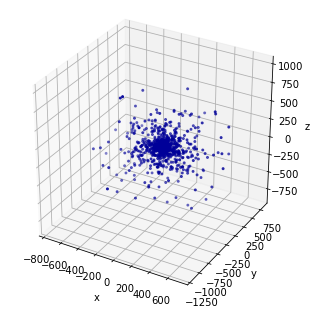

In [17]:
%matplotlib inline

plot(1000, isotropic_vector, 200, '#000099')

# Monte Carlo Simulation

We will now use the ideas introduced so far to simulate thermal neutrons passing though a slab of finite thinkness for three different materials: water, lead and graphite. We will start by determining the relevant parameters of these materials and then visualising the motion of a single neutron in these materials. After that, (without visualising,) we will simulate a large number of neutrons entering the slabs to determine the ratios of reflected, absorbed and transmitted particles. We will then vary the thickness of the materials to see how these rates change with slab thickness.

##  Determining cross sections and mean free paths of studies materials

The material parameters needed for the simulations are the macroscopic absorption and scattering cross sections, and the total mean free path in the material.

The macroscopic cross section of a material is the product of its microscopic cross section and its number density, $n=\frac{\rho N_A}{M}$. Therefore, the macroscopic absorption cross section $\Sigma_a = n\sigma_a$ and the macroscopic scattering cross section $\Sigma_s = n\sigma_s$ for each material.

The mean free path for a process is $\lambda = (n \sigma)^{-1} = 1/\Sigma$, so the total mean free path is $\lambda_T =  \frac{1}{\Sigma_a+\Sigma_s}$ considering both absorption and scattering.

The values used for the calculations are the following: 

|  | water | lead | graphite |
| :- | :-: | :-: | :-: |
| Absorption, $\sigma_a$ (barn) | 0.6652 | 0.158 | 0.0045 |
| Scattering, $\sigma_s$ (barn) | 103.0 | 11.221 | 4.74 |
| Density, $\rho$ (g/cm$^3$) | 1.00 | 11.35 | 1.67 |
| Molar Mass, $M$ (g/mol) | 18.0153 | 207.2 | 12.011 |

Firstly, we determine the macroscopic absorption and scattering cross-sections, as 
well as the total mean free path, for each material we will be studying.

In [18]:
AVOGADRO = 6.022E23

def material_parameters(mic_cross_sect_a, mic_cross_sect_s, density, molar):
    """
    This function calculates the macroscopic absorption and scattering cross sections in barns and the total mean free path
    of a material in centimetres.
    cross sections: barns
    densities: g/cm^3
    molar masses: g/mol
    """
    
    n = density*AVOGADRO*10**(-24)/molar # to get units correct - checked from mean free path of water in the absence of scattering
    cross_sect_a = n*mic_cross_sect_a
    cross_sect_s = n*mic_cross_sect_s
    cross_sect_t = cross_sect_a + cross_sect_s
    mean_free_path = 1/cross_sect_t
    return cross_sect_a, cross_sect_s, mean_free_path

cross_sect_a_water, cross_sect_s_water, mfp_water = material_parameters(0.6652, 103, 1.00, 18.0153)
cross_sect_a_lead, cross_sect_s_lead, mfp_lead = material_parameters(0.158, 11.221, 11.35, 207.2)
cross_sect_a_graphite, cross_sect_s_graphite, mfp_graphite = material_parameters(0.0045, 4.74, 1.67, 12.011)

## Visualising random walk

We can now visualise the path of a neutron through each material. We consider a slab with a thickness of $10cm$. The first step is taken perpendicular to the surface of the slab: the $y$ and $z$ coordinates are therefore 0 at the end of the first step and we restrict the step to be in the positive $x$-direction. After that, we generate a random unit vector, multiply it by a random length (generated according to the exponential distribution) and add its components to the coordinates of the particle (always keeping track of the previous ones). We stop when the particle leaves the slab ($x<0$ or $x>L$), or gets absorbed ($u<P_a$).

In [19]:
def random_walk(mfp, P_a, material_name):
    """
    This function plots the random walk of a particle through a material based on its mean free path. It has an additional check
    that re-runs the simulation until there are at least 10 steps to plot.
    """
    x = [] # needed to enter while loop
    
    while len(x) < 10: # make sure there are a decent amount of steps to plot
        
        # create empty arrays to contain coordinates of steps
        x = []
        y = []
        z = []
    
        # take first step (perpendicular to slab so only the x-coord is non-zero and it has to be positive)
        x_curr = np.abs(isotropic_vector(1, mfp)[:,0])
        y_curr = 0
        z_curr = 0
        
        # take a step if particle is within the slab
        while (0<x_curr<10):
            
            # add current positions to the arrays
            x = np.append(x, x_curr)
            y = np.append(y, y_curr)
            z = np.append(z, z_curr)

            # determine whether particle is absorbed and stop if it is
            prob = np.random.uniform()
            if (prob < P_a):
                break

            # generate next step if particle is not absorbed and update position
            step = isotropic_vector(1, mfp)
            x_curr += step[:,0]
            y_curr += step[:,1]
            z_curr += step[:,2]
        
        # append final values
        x = np.append(x, x_curr)
        y = np.append(y, y_curr)
        z = np.append(z, z_curr)
    
    #print outcome
    if x_curr > 10:
        print('Particle transmitted through ', material_name)       
    if x_curr < 0:
        print('Particle reflected from ', material_name)
    if (prob < P_a):
        print('Particle absorbed in' , material_name)

    # plot coordinates
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_title(material_name)
    ax.set_xlabel('x')
    ax.set_xlim(0, 10)
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_box_aspect(aspect=(1,1,1))
    ax.plot(x, y, z)
    ax.scatter(x, y, z, color='b', s = 4)

Particle reflected from  water
Particle transmitted through  lead
Particle reflected from  graphite


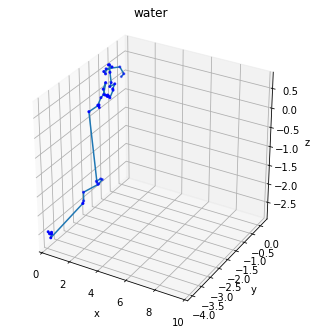

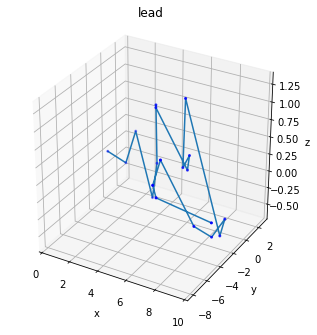

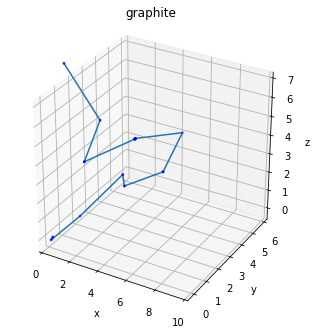

In [20]:
random_walk(mfp_water, cross_sect_a_water/(cross_sect_a_water+cross_sect_s_water), 'water')
random_walk(mfp_lead, cross_sect_a_lead/(cross_sect_a_lead+cross_sect_s_lead), 'lead')
random_walk(mfp_graphite, cross_sect_a_graphite/(cross_sect_a_graphite+cross_sect_s_graphite), 'graphite')

## Determining absorption, reflection and transmission rates

To determine the rates of absorption, reflection and transmission in each material, we can make a similar simulation to the one before. This time, we only need to consider the $x$-coordinate (as this is the one determining if a particle is reflected or transmitted) and we don't need to keep track of previous steps. We run it for a large number of neutrons to reduce the error (the error of the Monte Carlo method scales as $1/\sqrt{N}$) and repeat the simulation several times to finally average over the values of each. The uncertainty can then be calculated from the standard deviation of these values.

The logic to decide whether a particle is absorbed, reflected or transmitted after a step is the following:

- If the $x$-coordinate of a particle is larger than $L$, that means it has passed though the entire slab, therefore it counts as transmitted.
- If the $x$-coordinate of a particle is smaller than 0, it has been reflected.
- If neither of these is the case, a random number between 0 and 1 is generated. If this number is less $P_a$ calculated within the function, based on the absorption and scattering cross section parameters, the particle is absorbed.


These checks are performed for each particle at every step and the numbers for each category are updated. For the particles that weren't transmitted, relfected or absorbed, a new step is generated and these checks are performed again. This is repeated until there are no particles left within the slab.

In [21]:
def rates(N, absorption, scattering, mean_free_path, thickness):
    """
    This function determines the number of absorbed, reflected and transmitted neutrons out of N, when they enter a slab of
    a medium with known thickness (in cm), macroscopic absorption and scattering cross sections and mean free path.
    """
    L = thickness # cm
    x = exponential_generator(N, mean_free_path)
    P_a = absorption/(absorption+scattering)
    nR = 0
    nA = 0
    nT = 0
        
    while(len(x)>0):
        nR += np.count_nonzero(x<0) # reflected
        nT += np.count_nonzero(x>L) # transmitted
        prob = np.random.uniform(size=len(x))
        nA += np.count_nonzero(prob[np.argwhere((x>0) & (x<L))] < P_a) # number of absorbed neutrons
        x = np.delete(x,np.argwhere((x<0) | (x>L) | (prob < P_a)))
        x += exponential_generator(len(x), mean_free_path)*unit_vector(len(x))[:, 0]
    
    return nA, nR, nT

In [22]:
def data(N, absorption, scattering, mean_free_path, thickness, iterations):
    """
    This function runs rates() 'iterations' number of times and returns the average values of absorbed, reflected and
    transmitted neutron with their corresponding standard deviations.
    """
    values = np.zeros((3, iterations))
    for i in range(iterations):
        values[:,i] = rates(N, absorption, scattering, mean_free_path, thickness) # first row is nA values, second is nR, third is rT
    A = np.average(values[0])
    A_std = np.std(values[0])
    R = np.average(values[1])
    R_std = np.std(values[1])
    T = np.average(values[2])
    T_std = np.std(values[2])
    return A, A_std, R, R_std, T, T_std

We run the simulation for 10000 neturons, ten times for each material, for a thickness of 10cm and obtain the averaged values for the number of absorbed, transmitted and reflected neutrons. The standard deviation on these values from the 10 iterations can be used to find the error on each of these values.

In [23]:
neutron_number = 10000
slab_thickness = 10

wA, wA_std, wR, wR_std, wT, wT_std = data(neutron_number, cross_sect_a_water, cross_sect_s_water, mfp_water, slab_thickness, 10)
lA, lA_std, lR, lR_std, lT, lT_std = data(neutron_number, cross_sect_a_lead, cross_sect_s_lead, mfp_lead, slab_thickness, 10)
gA, gA_std, gR, gR_std, gT, gT_std = data(neutron_number, cross_sect_a_graphite, cross_sect_s_graphite, mfp_graphite, slab_thickness, 10)

In [24]:
def print_fixed_L_results(thickness, N, A, A_std, R, R_std, T, T_std, material):
    """
    This function prints the fraction of reflected, absorbed and transmitted neutrons for a material with uncentrainties.
    """
    print(' --------------------------------\n', material, '\n --------------------------------',
          '\n Fraction of Neutrons Reflected: {r:.5f} \u00B1 {e:.5f}'.format(r=R/N,e=R_std/R),
          '\n Fraction of Neutrons Absorbed: {a:.5f} \u00B1 {e:.5f}'.format(a=A/N,e=A_std/A),
          '\n Fraction of Neutrons Transmitted: {t:.5f} \u00B1 {e:.5f}'.format(t=T/N,e=T_std/T))
print('Transmission of ', neutron_number, ' neutrons though a slab with a thickness of', slab_thickness, 'cm')
print_fixed_L_results('10.00', neutron_number, wA, wA_std, wR, wR_std, wT, wT_std, 'Water')
print_fixed_L_results('10.00', neutron_number, lA, lA_std, lR, lR_std, lT, lT_std, 'Lead')
print_fixed_L_results('10.00', neutron_number, gA, gA_std, gR, gR_std, gT, gT_std, 'Graphite')

Transmission of  10000  neutrons though a slab with a thickness of 10 cm
 --------------------------------
 Water 
 -------------------------------- 
 Fraction of Neutrons Reflected: 0.79514 ± 0.00629 
 Fraction of Neutrons Absorbed: 0.20159 ± 0.02432 
 Fraction of Neutrons Transmitted: 0.00327 ± 0.15232
 --------------------------------
 Lead 
 -------------------------------- 
 Fraction of Neutrons Reflected: 0.61873 ± 0.00821 
 Fraction of Neutrons Absorbed: 0.10101 ± 0.02742 
 Fraction of Neutrons Transmitted: 0.28026 ± 0.01345
 --------------------------------
 Graphite 
 -------------------------------- 
 Fraction of Neutrons Reflected: 0.68446 ± 0.00703 
 Fraction of Neutrons Absorbed: 0.00823 ± 0.10094 
 Fraction of Neutrons Transmitted: 0.30731 ± 0.01494


The final results are presented as practions above. The error on the total number of reflected, transmitted or absorbed neutrons was taken to be the standard deviation of the results of the ten simulations. They were scaled (divided by $N_R, N_T$ and $N_A$ respectively) to represent fractions instead of total numbers.

To visualise these results, we can also create a pie chart for each material.

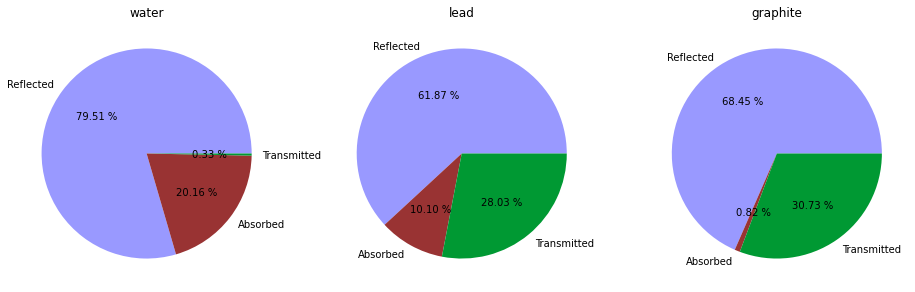

In [25]:
def pie_charts():
    labels = 'Reflected', 'Absorbed', 'Transmitted'
    water_vals = wR, wA, wT
    lead_vals = lR, lA, lT
    graphite_vals = gR, gA, gT
    colours = ['#9999ff', '#993333', '#009933']
    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            return '{p:.2f} %'.format(p=pct)
        return my_autopct
    
    fig, ax = plt.subplots(1,3)
    fig.set_figheight(12)
    fig.set_figwidth(16)
    ax[0].set_title('water')
    ax[0].pie(water_vals, labels=labels, autopct=make_autopct(water_vals), colors=colours)
    ax[1].set_title('lead')
    ax[1].pie(lead_vals, labels=labels, autopct=make_autopct(lead_vals), colors=colours)
    ax[2].set_title('graphite')
    ax[2].pie(graphite_vals, labels=labels, autopct=make_autopct(graphite_vals), colors=colours)
pie_charts()

For a thickness of 10 cm, we can see that water reflects the majority of the neutrons and absorbs almost all remaining ones. Lead and graphite let thorugh roughly a third of the incoming particles. Graphite only absorbs a very small fraction and reflects the rest of the particles, while lead absorbs about 10% of the total particles.

## Variation with slab thickness

We can study how these rates vary as the slab thickness varies for each material. For this, we can create a range of thicknesses and and follow the same steps as before to get absorption, relfection and transmission values for each thickness. We space the chosen values more closely for smaller thicknesses as we expect more variation there. We can then plot these rates as a function of the thickness to see how they vary. In the same way as for water in the introductiory section, we can find the characteristic attenuation length for each material.

In [26]:
thicknesses = np.geomspace(1, 20, 20) # cm

results_water = np.zeros((len(thicknesses), 6))
results_lead = np.zeros((len(thicknesses), 6))
results_graphite = np.zeros((len(thicknesses), 6))

# run the data() function for each thickness and store results in arrays
for index, l in enumerate(thicknesses):
    results_water[index] = data(neutron_number, cross_sect_a_water, cross_sect_s_water, mfp_water, l, 10)
    results_lead[index] = data(neutron_number, cross_sect_a_lead, cross_sect_s_lead, mfp_lead, l, 10)
    results_graphite[index] = data(neutron_number, cross_sect_a_graphite, cross_sect_s_graphite, mfp_graphite, l, 10)

In [27]:
def results(material, values):
    """
    This function plots the variation of absorption, reflection and transmission rates with slab thickness. It then takes the
    logarithm of the fraction of neutrons transmitted and fits a straight line to the data. It then determines the
    characteristic attenuation length of the material from the coefficients of the fit.
    """
    fig, ax = plt.subplots(1, 4)
    fig.set_figheight(6)
    fig.set_figwidth(16)
    ax[0].errorbar(thicknesses, values[:,0]/neutron_number, yerr = values[:,1]/neutron_number, color = 'black', ls='none')
    ax[0].scatter(thicknesses, values[:,0]/neutron_number)
    ax[1].errorbar(thicknesses, values[:,2]/neutron_number, yerr = values[:,3]/neutron_number, color = 'black', ls='none')
    ax[1].scatter(thicknesses, values[:,2]/neutron_number)
    ax[2].errorbar(thicknesses, values[:,4]/neutron_number, yerr = values[:,5]/neutron_number, color = 'black', ls='none')
    ax[2].scatter(thicknesses, values[:,4]/neutron_number)
    ax[0].set_title('absorption')
    ax[0].set_xlabel('x (cm)')
    ax[0].set_ylabel('fraction')
    ax[1].set_title('reflection')
    ax[1].set_xlabel('x (cm)')
    ax[1].set_ylabel('fraction')
    ax[2].set_title('transmission')
    ax[2].set_xlabel('x (cm)')
    ax[2].set_ylabel('fraction')
    
    # polyfit to log of transmission rates
    x_fit = np.delete(thicknesses,np.argwhere(values[:,4]==0))
    y_fit_err = np.delete(values[:,5],np.argwhere(values[:,4]==0)) # standard deviations
    y_fit = np.delete(values[:,4],np.argwhere(values[:,4]==0))
    
    # fit can be to total number or rate as well
    ax[3].errorbar(x_fit, np.log(y_fit), yerr=y_fit_err/y_fit, color = 'black', ls='none')
    ax[3].scatter(x_fit, np.log(y_fit))
    ax[3].set_xlabel('x (cm)')
    ax[3].set_ylabel('log(number of transmitted particles)')
    fit_params, fit_err = np.polyfit(x_fit, np.log(y_fit), 1, cov=True, w = y_fit/y_fit_err)
    ax[3].plot(x_fit, fit_params[0]*x_fit+fit_params[1], color = '#ffcc00')
    plt.tight_layout()
    ax[3].set_title('attenuation lengths')
    
    lamb = -1/fit_params[0]
    lamb_err = np.abs(np.sqrt(fit_err[0][0])/fit_params[0])
    print('The characteristic attenuation length for ', material, 'is 𝜆 = {:04.4f} \u00B1 {:04.4f} cm'.format(lamb, lamb_err))

The characteristic attenuation length for  water is 𝜆 = 1.8708 ± 0.0177 cm


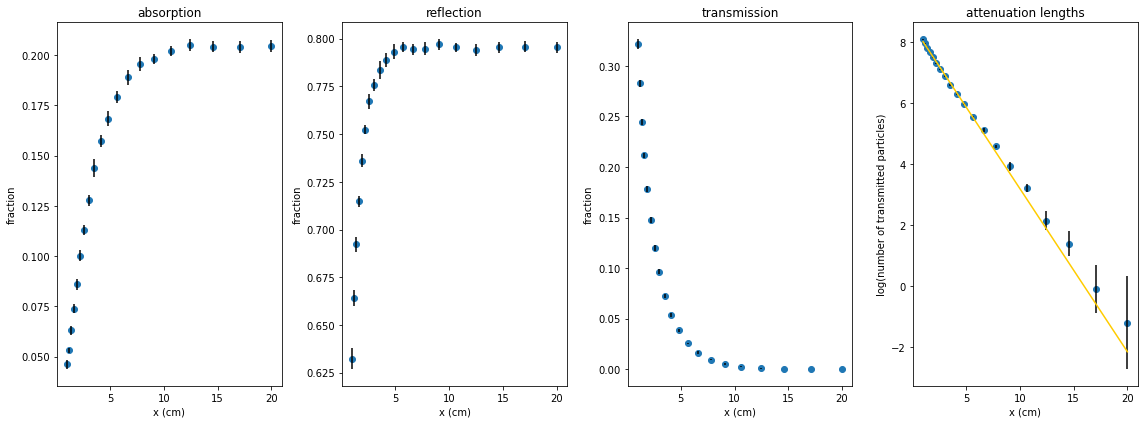

In [28]:
results('water', results_water)

The characteristic attenuation length for  lead is 𝜆 = 8.6485 ± 0.0292 cm


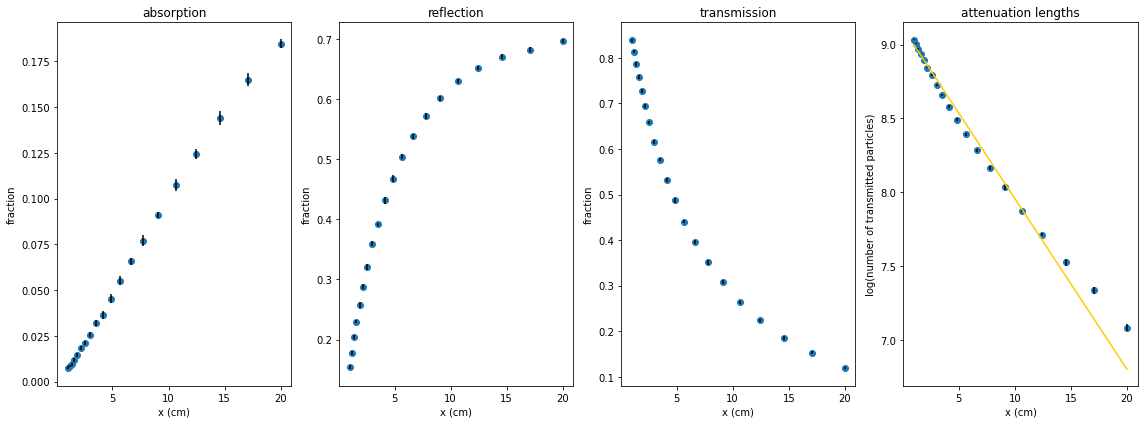

In [29]:
results('lead', results_lead)

The characteristic attenuation length for  graphite is 𝜆 = 10.4814 ± 0.0494 cm


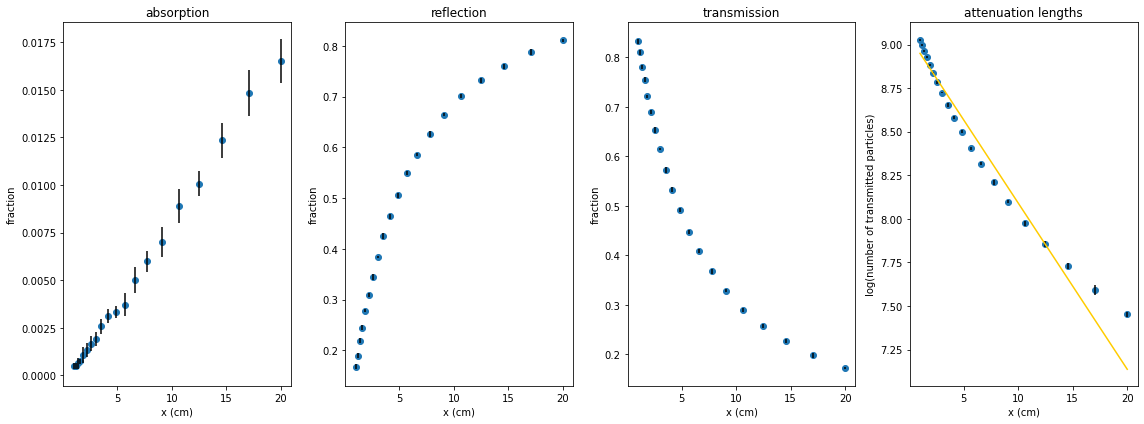

In [30]:
results('graphite', results_graphite)

# Conclusions

When choosing a shielding material against thermal neutrons, out of the three materials considered, water seems to be the best choice. The pie charts showed that for a slab of 10cm, water absorbs or reflects over 99% of the incoming neutrons. Later, when looking at the variation of the rates with thickness, deduced the characteristic attenuation length for each of these materials. It is shortest for water, and is of the same order (roughly ten times as much) for lead and graphite, which confirms that neutrons in the latter two materials can penetrate further than in water.

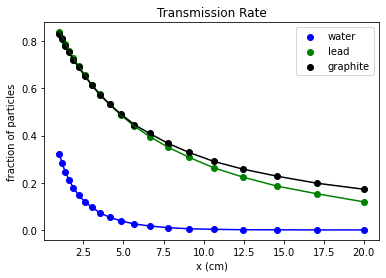

In [31]:
def thickness_variation(index, title):
    """
    This function compares the rate of a chosen process for the three studies materials with thickness.
    Index 0 for absorption, 2 for reflection and 4 for transmission.
    """
    plt.plot(thicknesses, results_water[:,index]/neutron_number, color = 'b')
    plt.scatter(thicknesses, results_water[:,index]/neutron_number, color = 'b', label = 'water')
    plt.plot(thicknesses, results_lead[:,index]/neutron_number, color = 'green')
    plt.scatter(thicknesses, results_lead[:,index]/neutron_number, color = 'green', label = 'lead')
    plt.plot(thicknesses, results_graphite[:,index]/neutron_number, color = 'k')
    plt.scatter(thicknesses, results_graphite[:,index]/neutron_number, color = 'k', label = 'graphite')
    plt.title(title)
    plt.xlabel('x (cm)')
    plt.ylabel('fraction of particles')
    plt.legend()
    plt.show()

thickness_variation(4, 'Transmission Rate')

Comparing the rate of transmitted particles clearly shows this, too, as for water, the rate of transmitted particles drops to zero at a much smaller distance (around 8cm) than for lead and graphite, which both still have a significant fraction of transmitted particles at a thickness of 20cm.

Therefore, for shielding against a beam of thermalised neutrons, water would be the most efficient out of the three studied materials, and a thickness of around 12 cm could be enough to capture all incoming particles.